<a href="https://colab.research.google.com/github/FireDragon00/LaTeX-Template-Cn/blob/master/DGL_graph_generate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dgl
!pip install torch

     |████████████████████████████████| 4.4 MB 3.2 MB/s 


挂载谷歌硬盘

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### 初始化参数

In [3]:
root_path = '/content/drive/MyDrive/SAME'

In [4]:
import pandas as pd
!pip install pandas
import dgl
import os
import torch
import numpy as np

N = 20
t = 10
k = 10  # the number of rows for the output tensor (k = 10, 20)
T = 5
overlap = 3  # note: overlap depends on T

apps = ['diijam', 'myradio', 'spotify', 'nhaccuatui', 'soundcloud', 'sachnoiapp', 'truyenaudiosachnoiviet', 'voizfm', 'tunefm', 'radiofm']

features = ['complete_max', 'complete_min', 'complete_mean', 'complete_mad', 'complete_std', 'complete_var',
            'complete_skew',
            'complete_kurt', 'complete_pkt_num', 'complete_10per', 'complete_20per', 'complete_30per', 'complete_40per',
            'complete_50per',
            'complete_60per', 'complete_70per', 'complete_80per', 'complete_90per', 'out_max', 'out_min', 'out_mean',
            'out_mad', 'out_std',
            'out_var', 'out_skew', 'out_kurt', 'out_pkt_num', 'out_10per', 'out_20per', 'out_30per', 'out_40per',
            'out_50per', 'out_60per',
            'out_70per', 'out_80per', 'out_90per', 'in_max', 'in_min', 'in_mean', 'in_mad', 'in_std', 'in_var',
            'in_skew', 'in_kurt',
            'in_pkt_num', 'in_10per', 'in_20per', 'in_30per', 'in_40per', 'in_50per', 'in_60per', 'in_70per',
            'in_80per', 'in_90per']

train_graphs_folder = os.path.join(root_path, '%d_%d/train_graphs/N%d/t%d' % (T, overlap, N, t))
test_graphs_folder = os.path.join(root_path, '%d_%d/test_graphs/N%d/t%d' % (T, overlap, N, t))


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


### 加载某个app的所有图

In [5]:
'''
Load graphs for one app
Input: app and folder that contains graphs of the app
Output: List of graphs (StellarGraph objects) and List of labels
'''


def graphs_one_app(app, graphs_folder):
	graphs = []

	app_graph_folder = os.path.join(graphs_folder, app)
	features_path = os.path.join(app_graph_folder, 'features.csv')
	weights_path = os.path.join(app_graph_folder, 'weights.csv')

	features_df = pd.read_csv(features_path, index_col=0)
	weights_df = pd.read_csv(weights_path, index_col=0)

	graph_num = features_df['graph_id'].iloc[-1]
	# loop over all graphs of the app
	for i in range(1, graph_num + 1):
		feature_df = features_df[features_df['graph_id'] == i]
		feature_df = feature_df[['IP_port'] + features + ['graph_id']]
		weight_df = weights_df[weights_df['graph_id'] == i]

		# drop graph_id column
		feature_df = feature_df.drop(['graph_id'], axis=1)
		weight_df = weight_df.drop(['graph_id'], axis=1)
	
		# ip_port to node_id
		ip_port = list(pd.concat([weight_df['source'], weight_df['target']]).value_counts().index)
		node_id = [i for i in range(len(ip_port))]

		weight_df = weight_df.replace(ip_port,node_id)
		feature_df = feature_df.replace(ip_port, node_id).sort_values(by=['IP_port']).set_index('IP_port')
	
		# .reset_index(drop=True)


		if weight_df.shape[0] > 0:
			
			u, v = torch.tensor(pd.concat([weight_df['source'],weight_df['target']]).values.astype('int32')),\
			torch.tensor(pd.concat([weight_df['target'],weight_df['source']]).values.astype('int32'))
			# print(u)
			g = dgl.graph((u, v))
	 
			weights = torch.tensor(pd.concat([weight_df['weight'],weight_df['weight']]).values.astype('float32'))
			g.edata['w'] = weights

			feats = torch.tensor(np.array(feature_df.values).astype('float32'))
			g.ndata['attr'] = feats
			graphs.append(g)
			# print(g)

	return graphs


### 加载所有app的图

In [6]:
'''
Load all graphs
Input: folder that contains graphs
Output: List of graphs (StellarGraph objects), List of graph_labels (dummy values) and List of labels (names of app)
'''


def generate_graphs(graphs_folder):
	# build a list of graphs and labels: note that only apply for more than 2 classes
	li = []
	labels = []
	idx = 0

	for app in apps:
		idx += 1
		print('Loading {} ... {}/{}'.format(app, idx, len(apps)))

		one_app_graphs = graphs_one_app(app, graphs_folder)
		print(len(one_app_graphs))
		one_app_labels = [idx for _ in range(len(one_app_graphs))]
		print(len(one_app_labels))
		li.extend(one_app_graphs)
		labels.extend(one_app_labels)

	graph_labels = labels
	graphs = li

	print('...............................................................')

	return graphs, graph_labels


### 训练集和测试集

In [7]:
train_graphs, train_graph_labels = generate_graphs(train_graphs_folder)
test_graphs, test_graph_labels = generate_graphs(test_graphs_folder)
train_size = len(train_graphs)

Loading diijam ... 1/10
406
406
Loading myradio ... 2/10
586
586
Loading spotify ... 3/10
866
866
Loading nhaccuatui ... 4/10
1200
1200
Loading soundcloud ... 5/10
818
818
Loading sachnoiapp ... 6/10
660
660
Loading truyenaudiosachnoiviet ... 7/10
275
275
Loading voizfm ... 8/10
649
649
Loading tunefm ... 9/10
360
360
Loading radiofm ... 10/10
452
452
...............................................................
Loading diijam ... 1/10
109
109
Loading myradio ... 2/10
147
147
Loading spotify ... 3/10
218
218
Loading nhaccuatui ... 4/10
300
300
Loading soundcloud ... 5/10
209
209
Loading sachnoiapp ... 6/10
167
167
Loading truyenaudiosachnoiviet ... 7/10
60
60
Loading voizfm ... 8/10
161
161
Loading tunefm ... 9/10
85
85
Loading radiofm ... 10/10
113
113
...............................................................


In [8]:
print(len(train_graph_labels))
print(len(test_graph_labels))

6272
1569


### 创建dataset类，方便训练

In [9]:
from dgl.data import DGLDataset

class Traindataset(DGLDataset):
  _url = 'http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/qm7b.mat'
  _sha1_str = '4102c744bb9d6fd7b40ac67a300e49cd87e28392'

  def __init__(self, raw_dir=None, force_reload=False, verbose=False):
    super().__init__(name='qm7b',
            url=self._url,
            raw_dir=raw_dir,
            force_reload=force_reload,
            verbose=verbose)

  def process(self):
    # 将数据处理为图列表和标签列表
    self.graphs, self.label = train_graphs, torch.tensor(train_graph_labels)

  def __getitem__(self, idx):
    """ 通过idx获取对应的图和标签

    Parameters
    ----------
    idx : int
        Item index

    Returns
    -------
    (dgl.DGLGraph, Tensor)
    """
    return self.graphs[idx], self.label[idx]

  def __len__(self):
    """数据集中图的数量"""
    return len(self.graphs)
  
  @property
  def num_labels(self):
    return 10

### GATmodel

In [22]:
import dgl
import torch
import dgl.nn.pytorch as dglnn
import torch.nn as nn
from dgl.nn.pytorch.conv import GATConv
from dgl.nn.pytorch.conv import DenseGraphConv
from dgl.nn.pytorch.glob import SortPooling
import torch.nn.functional as F


class Classifier(nn.Module):
  def __init__(self, in_dim, hidden_dim, n_classes, batch_size, num_graph):
    super(Classifier, self).__init__()
    self.batch_size = batch_size
    self.num_graph = num_graph
    self.gat1 = GATConv(in_dim, hidden_dim, 5)
    self.gat2 = GATConv(hidden_dim*5, hidden_dim, 5)
    
    #l2_out: torch.Size([3371, 5, 20])==>l2_flatten: torch.Size([3371, 100])
    self.sortpooling = SortPooling(k=16)
    #sortpool: torch.Size([1024, 1600])
    self.conv1D_1 = nn.Conv1d(1, 128, kernel_size=3)
    self.maxpooling = nn.MaxPool1d(3)
    self.conv1D_2 = nn.Conv1d(128, 256, kernel_size=2)
    self.classify = nn.Linear(256*531, n_classes)

  def forward(self, g, h):
    # print('raw_shape:',h.size())
    # GATConv
    h = F.relu(self.gat1(g, h))
    # print('l1_out:', h.size())
    h = h.flatten(1)
    # print('l1_flatten:', h.size())
    h = F.relu(self.gat2(g, h))
    # print('l2_out:', h.size())
    h = h.flatten(1)
    # print('l2_flatten:', h.size())

    # sortpool——图池化
    h = self.sortpooling(g, h)
    # print('pool1:', h.size())
    try:
      h = h.view(1024, 1, 1600)
    except:
      x = self.num_graph % self.batch_size
      h = h.view(x , 1, 1600)
    # print('view:', h.size())
    h = self.conv1D_1(h)
    # print('conv1:', h.size())
    h = self.maxpooling(h)
    # print('pool2:', h.size())
    h = self.conv1D_2(h)
    # print('conv2:', h.size())
    h = F.relu(h.flatten(1))
    h = F.dropout(h)
    with g.local_scope():
        return self.classify(h)

In [11]:
from dgl.dataloading import GraphDataLoader

dataset = Traindataset()
dataloader = GraphDataLoader(
  dataset,
  batch_size=1024,
  drop_last=False,
  shuffle=True)
print(dataset[0])

(Graph(num_nodes=9, num_edges=72,
      ndata_schemes={'attr': Scheme(shape=(54,), dtype=torch.float32)}
      edata_schemes={'w': Scheme(shape=(), dtype=torch.float32)}), tensor(1))


In [26]:
model = Classifier(54, 20, 11, 1024, 6272)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

epoch_losses = []
for epoch in range(50):
  epoch_loss = 0
  i = 0
  for batched_graph, labels in dataloader:
      feats = batched_graph.ndata['attr']
      logits = model(batched_graph, feats)
      # print(logits.size())
      loss = F.cross_entropy(logits, labels)
      opt.zero_grad()
      loss.backward()
      opt.step()
      epoch_loss += loss.detach().item()
      i += 1
  epoch_loss /= (i+1)
  print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
  epoch_losses.append(epoch_loss)


Epoch 0, loss 3.7414
Epoch 1, loss 1.8500
Epoch 2, loss 1.5953
Epoch 3, loss 1.3697
Epoch 4, loss 1.1792
Epoch 5, loss 1.0091
Epoch 6, loss 0.8517
Epoch 7, loss 0.7682
Epoch 8, loss 0.7057
Epoch 9, loss 0.6575
Epoch 10, loss 0.5909
Epoch 11, loss 0.5458
Epoch 12, loss 0.5127
Epoch 13, loss 0.4552
Epoch 14, loss 0.4417
Epoch 15, loss 0.4219
Epoch 16, loss 0.3826
Epoch 17, loss 0.3859
Epoch 18, loss 0.3685
Epoch 19, loss 0.3414
Epoch 20, loss 0.3335
Epoch 21, loss 0.2979
Epoch 22, loss 0.2964
Epoch 23, loss 0.2929
Epoch 24, loss 0.2812
Epoch 25, loss 0.2724
Epoch 26, loss 0.2591
Epoch 27, loss 0.2389
Epoch 28, loss 0.2256
Epoch 29, loss 0.2332
Epoch 30, loss 0.2121
Epoch 31, loss 0.2048
Epoch 32, loss 0.1892
Epoch 33, loss 0.1918
Epoch 34, loss 0.1865
Epoch 35, loss 0.1779
Epoch 36, loss 0.1736
Epoch 37, loss 0.1724
Epoch 38, loss 0.1719
Epoch 39, loss 0.1409
Epoch 40, loss 0.1770
Epoch 41, loss 0.1687
Epoch 42, loss 0.1673
Epoch 43, loss 0.1593
Epoch 44, loss 0.1392
Epoch 45, loss 0.133

损失曲线

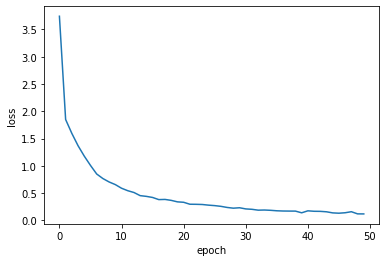

In [27]:
import matplotlib.pyplot as plt
!pip install matplotlib


plt.xlabel("epoch")
plt.ylabel("loss")#
plt.plot(epoch_losses)
plt.show()

In [28]:
# Test the model
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for batched_graph, labels in dataloader:
        feats = batched_graph.ndata['attr']
        outputs = model(batched_graph, feats)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test accuracy of the model on the 1024 test batched_graph: {} %'
          .format(100 * correct / total))

Test accuracy of the model on the 1024 test batched_graph: 95.64732142857143 %
